# 1 Sentiment analysis with GRU

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Sun Mar 12 20:39:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')

Preparing the enviroment.This step is also important,because Torchtext Field has been removed in the latest version.We need to install the version of torchtext 0.9.0 and pytorch  1.8.0 with cuda 11.1

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.8.0+cu111 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.8.0+c

## 1.1 Data preparation

First, as usual, we import the library and set the random seed

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Then determine whether the machine is using a CPU or a GPU for training (this step is critical, if it is a CPU it will take much more time than a GPU for this kind of training)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


Preparing the enviroment.This step is also important,because Torchtext Field has been removed in the latest version.We need to install the version of torchtext 0.9.0 and pytorch  1.8.0 with cuda 11.1

In [ ]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.8/668.8 kB 55.7 MB/s eta 0:00:00
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.3.0-py3-none-any.whl size=12799906 sha256=1b5644f3386396b6c18ff57a9afced4d22c17878374c10271c1ba4f03c310142
  Stored in directory: /root/.cache/pip/wheels/59/45/a8/3b4da8b234b490b85991ad56d00ee1df35d26ea29dc542cad4
Successfully built en-core-web-sm
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
 

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


Now we start defining our fields, the transformer expects the batch dimension to be on the first dimension, so we set `batch_first = True`. Now that we have the lexical data for the text, provided by the transformer, we set `use_vocab = False` to tell torchtext that we don't need to slice the data anymore. We pass the `tokenize_and_cut` function as the tokenizer. The `preprocessing` argument is a function, and this is where we convert the token to its index. Finally, we define special tokens - note that we define them as their index value rather than their string value, i.e. `100' rather than `[UNK] " this is because the sequence has been converted to an index.

We define the tag fields as before.

In [ ]:
from torchtext.legacy import data

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

Load the data and split it into a training and validation set

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 38.4MB/s]


In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:13<00:00, 30083.38it/s]


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


As before, we create the iterator. From past experience, using the largest batch size gives the best results for the transformer, but you can of course try using other batch sizes if you have a better graphics card.

In [ ]:
BATCH_SIZE = 128


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# 1.2 Building the model

Next, we import the pre-trained model.

In [ ]:
import torch.nn as nn

class GRUSentiment(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                 pad_idx):

        super().__init__()

        super().__init__()
        # embedding layer(word vector)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):

        #shape of text [sent len, batch size]

        embedded = self.dropout(self.embedding(text))

        #shape of embedded [sent len, batch size, emb dim]

        # pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, hidden = self.rnn(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #shape ofoutput[sent len, batch size, hid dim * num directions]
        #The padding tokens in the output are tensors with a value of 0

        #shape of hidden [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        #shape of hidden [batch size, hid dim * num directions]

        return self.out(hidden)


We use standard hyperparameters to create instances of the model.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
# 250002: Previously set to take only the 25,000 most frequent words
#plus pad_token and unknown token
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
#Specify the parameter that defines the index value of the pad_token
#so that the model does not care about the pad token.

model = GRUSentiment(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

We can check how many parameters the model has. Our standard model has less than 5M parameters, but this model has 112M Fortunately, and with 110M of these parameters coming from the transformer, we don't have to train them again.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,233,321 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
# Checking the shape of word vectors [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
# Replace the weight parameters initialized by the original model with the pre-trained embedding word vector
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.9035, -0.2152,  0.4299,  ..., -0.3206, -0.5546,  0.7158],
        [-0.0769, -0.2702, -0.3047,  ...,  0.5782, -0.5734, -0.2524],
        [-0.5669,  0.5366, -0.3153,  ...,  0.1376,  1.0980,  0.0468]])

In [ ]:
#Set Unknown and Filler to 0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.9035, -0.2152,  0.4299,  ..., -0.3206, -0.5546,  0.7158],
        [-0.0769, -0.2702, -0.3047,  ...,  0.5782, -0.5734, -0.2524],
        [-0.5669,  0.5366, -0.3153,  ...,  0.1376,  1.0980,  0.0468]])


We can double check the names of the trainable parameters to make sure they make sense. We can see that they are all parameters of the GRU (`rnn`) and the linear layer (`out`).

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

embedding.weight
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## 1.3 Training the model

As usual, we construct our own model evaluation criteria (loss function), which is still binary

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Put the model and evaluation criteria (loss function) on the GPU

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Next, we will define functions for: calculating accuracy, defining the train, evalute functions and calculating the time required for each epoch of the training/evaluation period.

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad() # Gradient clearing

        text, text_lengths = batch.text
# batch.text returns a tuple (a tensor of digits, the length of each sentence)

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        # Gradient cropping to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text
#batch.text returns a tuple (a tensor of digits, the length of each sentence)

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we will train our model. This is much longer than any previous model due to the size of the transformer. Even if we don't train any of the transformer's parameters, we still need to pass data through the model, which can take a lot of time on a standard GPU.

In [ ]:
import matplotlib.pyplot as plt

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 0.641 | Train Acc: 62.37%
	 Val. Loss: 0.572 |  Val. Acc: 69.85%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.533 | Train Acc: 74.80%
	 Val. Loss: 0.455 |  Val. Acc: 79.97%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.382 | Train Acc: 83.86%
	 Val. Loss: 0.300 |  Val. Acc: 87.52%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.324 | Train Acc: 86.52%
	 Val. Loss: 0.307 |  Val. Acc: 88.07%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.278 | Train Acc: 88.85%
	 Val. Loss: 0.272 |  Val. Acc: 89.60%


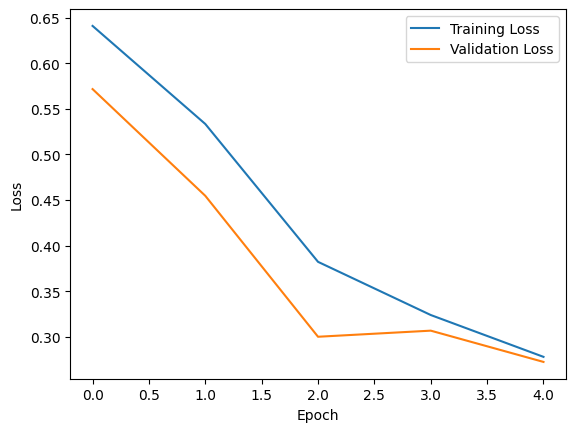

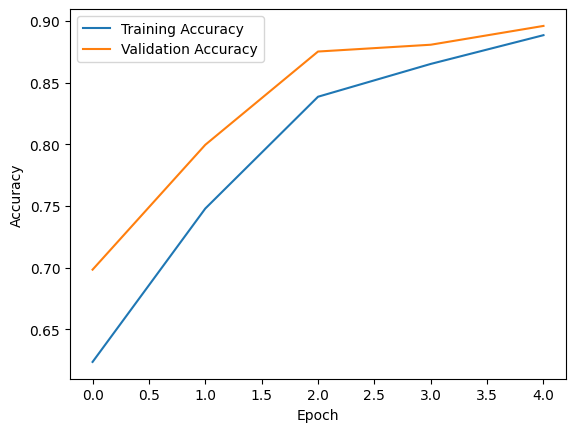

In [ ]:
N_EPOCHS = 5
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut7-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We will load the parameters that provide us with the best loss values on the validation set and apply these parameters on the test set - and achieve the optimal results on the test set.

In [ ]:
model.load_state_dict(torch.load('./tut7-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.298 | Test Acc: 88.35%


## 1.4 Model validation

We will then use the model to test the sentiment of a number of sequences. We tokenise the input sequence, trim it to maximum length, add the special token to either side, convert it to a tensor, add one dimension using the unsqueeze function, and pass it to our model.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    # return prediction.item()
    if prediction >= 0.75:
      print(prediction.item(),"This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
      print(prediction.item(),"This sentence represents a weak postive emotion.")
    elif 0.45<= prediction and prediction <= 0.55:
      print(prediction.item(),"This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
      print(prediction.item(),"This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
      print(prediction.item(),"This sentence represents a strong negative emotion.")

Examples of positive comments.

In [ ]:
predict_sentiment(model, "I don't want meet him.")

0.31203633546829224 This sentence represents a weak negative emotion.


In [ ]:
predict_sentiment(model, "All sins are rooted in two major sins, anxiety and laziness.")

0.1280018389225006 This sentence represents a strong negative emotion.


Examples of negative comments.

In [ ]:
predict_sentiment(model,"Dinner is scrumptious!")

0.5168128609657288 This sentence represents a neutral emotion.


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Set thresholds
threshold = 0.5

# Disable gradient calculation
with torch.no_grad():
    model.eval()
    y_true = []
    y_pred = []

    for batch in test_iterator:
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        # Convert output values to categories
        preds = torch.sigmoid(predictions) > threshold
        y_pred.extend(preds.tolist())
        y_true.extend(batch.label.tolist())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)
# Normalised confusion matrix
cm_norm = normalize(cm, axis=1, norm='l1')
print(cm_norm)

[[11474  1026]
 [ 1870 10630]]
[[0.91792 0.08208]
 [0.1496  0.8504 ]]


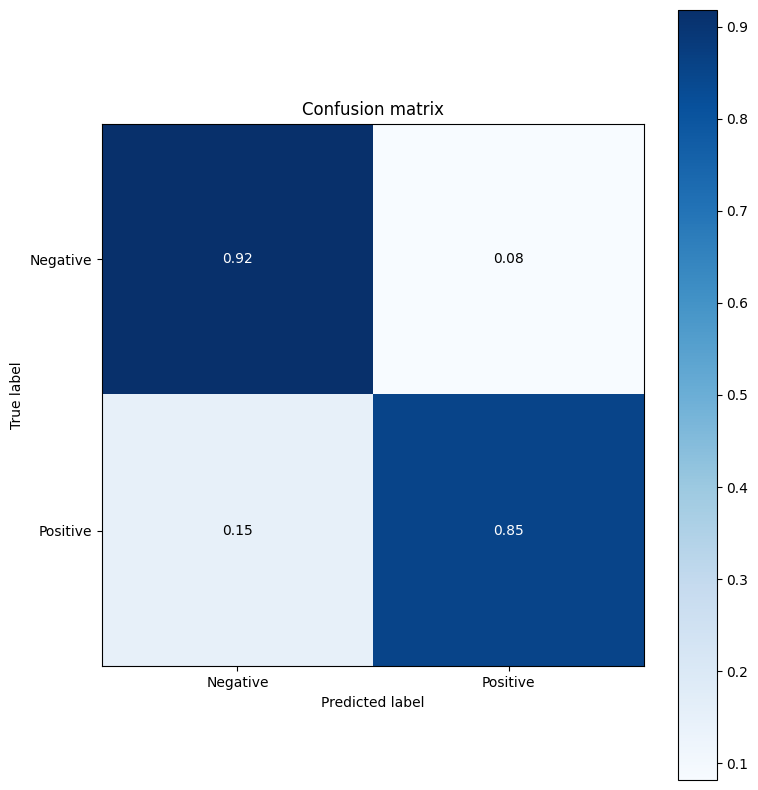

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up tags
labels = ['Negative', 'Positive']

# Draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add a comment
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculation of assessment indicators
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = recall

print(f"Confusion Matrix:\n{cm_norm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

Confusion Matrix:
[[0.91792 0.08208]
 [0.1496  0.8504 ]]
Accuracy: 0.8842
Precision: 0.9120
Recall: 0.8504
Specificity: 0.9179
Sensitivity: 0.8504


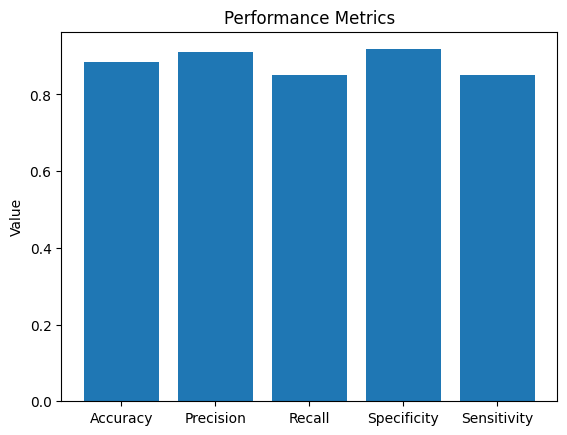

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the assessment indicators from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
sensitivity = recall

# Putting indicators into arrays for plotting
ind = np.arange(5)
vals = [accuracy, precision, recall, specificity, sensitivity]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'Sensitivity']

# Plotting bar charts
plt.bar(ind, vals)
plt.xticks(ind, labels)
plt.ylabel('Value')
plt.title('Performance Metrics')
plt.show()
